In [124]:
import json
import pandas as pd

f = open("data/goldPrice.json", "r")
str_data = f.read()
f.close()
json_data = json.loads(str_data)

data_list = []
for item in json_data["vector"]["data"]:
    if item["LIST"]["CUR_NM"]["_value"] == "1USD":
        this_data = {}
    for k, v in item["LIST"].items():
        if k == "NTC_DT":
            this_data[k] = v["_value"]
        elif k == "TRD_BAS_EXRT":
            if "TRD_BAS_EXRT" in this_data:
                this_data["WON"] = float(v["_value"])
            else:
                this_data[k] = float(v["_value"])
    if item["LIST"]["CUR_NM"]["_value"] != "1USD":
        data_list.append(this_data)
    
df = pd.DataFrame(data_list)
df["GOLD_PRICE"] = df["WON"]/df["TRD_BAS_EXRT"] * (31.1034768/0.9999)
df.rename(columns={"NTC_DT" : "DATE"}, inplace=True)
df.drop(columns=["TRD_BAS_EXRT", "WON"], axis=1, inplace=True)
df

,DATE,GOLD_PRICE
0,20031103,383.582664
1,20031104,377.483295
2,20031105,381.148687
3,20031106,383.368804
4,20031107,381.402585
...,...,...
4434,20210906,1824.808981
4435,20210907,1814.581020
4436,20210908,1798.809989
4437,20210909,1795.198416


In [125]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["YM_PRD"] = df["DATE"].dt.to_period(freq="M")
df["YM_DT"] = ""
for i in range(len(df["YM_PRD"])):
    df.iloc[i, 3] = str(df.iloc[i, 2])
df["YM_DT"] = pd.to_datetime(df["YM_DT"])
df

,DATE,GOLD_PRICE,YM_PRD,YM_DT
0,2003-11-03,383.582664,2003-11,2003-11-01
1,2003-11-04,377.483295,2003-11,2003-11-01
2,2003-11-05,381.148687,2003-11,2003-11-01
3,2003-11-06,383.368804,2003-11,2003-11-01
4,2003-11-07,381.402585,2003-11,2003-11-01
...,...,...,...,...
4434,2021-09-06,1824.808981,2021-09,2021-09-01
4435,2021-09-07,1814.581020,2021-09,2021-09-01
4436,2021-09-08,1798.809989,2021-09,2021-09-01
4437,2021-09-09,1795.198416,2021-09,2021-09-01


In [126]:
df_ym = df.groupby(by="YM_DT")
df_ym = df_ym.mean()
# df_ym.reset_index(inplace=True)
display(df_ym)
# df_ym["new_ym"] = pd.to_datetime(df_ym["YM"])
# df_ym["YM"] = df_ym["YM"].asfreq('D', how='start').to_timestamp()
# df_ym["YM"]
# df_ym["YM"] = df_ym[]

,GOLD_PRICE
YM_DT,
2003-11-01,390.747128
2003-12-01,408.189598
2004-01-01,415.522090
2004-02-01,405.452871
2004-03-01,406.940326
...,...
2021-05-01,1850.946544
2021-06-01,1836.599256
2021-07-01,1806.369602


<AxesSubplot:xlabel='YM_DT'>

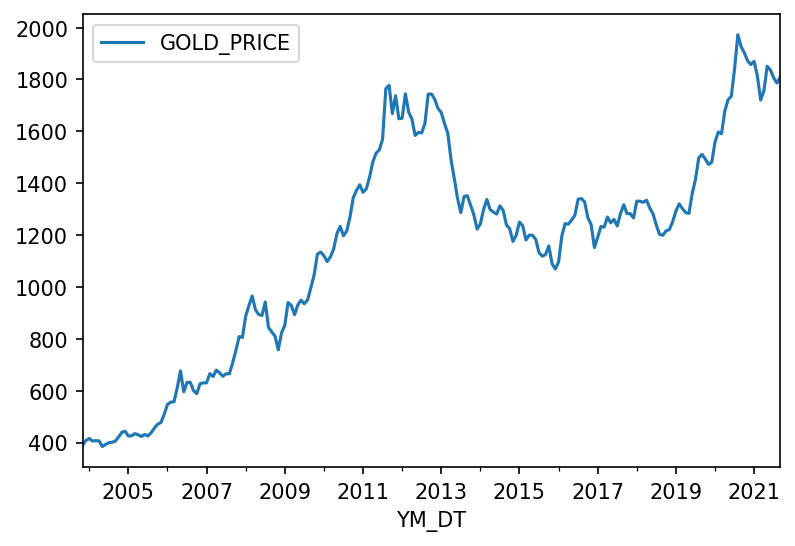

In [127]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=150)
ax = fig.subplots()
df_ym.plot(ax = ax)
# plt.plot(df_ym["YM"], df_ym["GOLD_PRICE"])

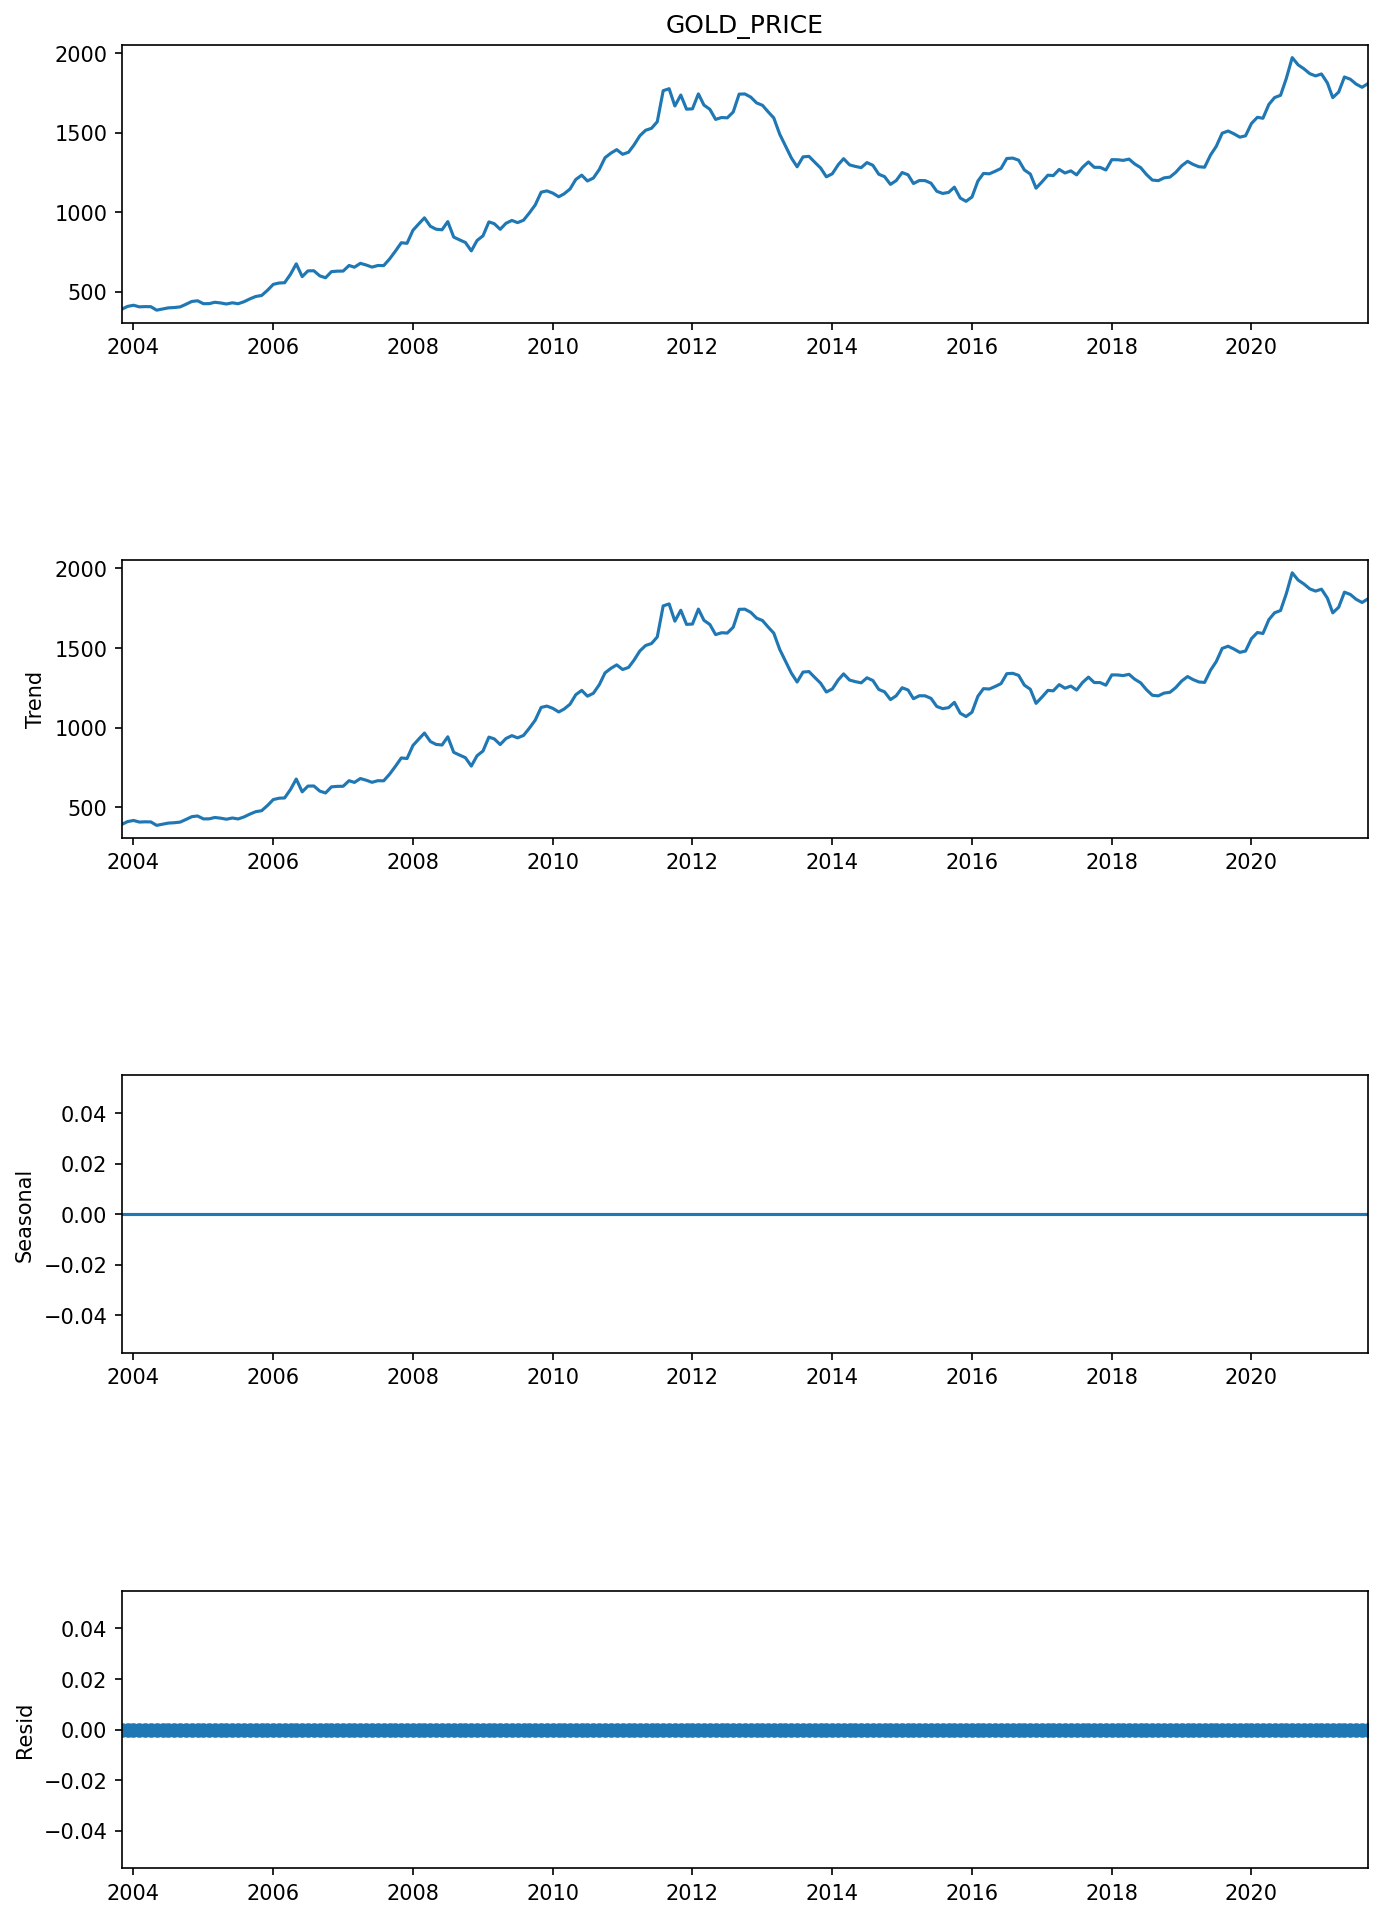

In [129]:
import statsmodels.api as sm
#Decomposition of Time Series
decomposition = sm.tsa.seasonal_decompose(df_ym["GOLD_PRICE"], model="additive", period=1)
fig = decomposition.plot()
fig.dpi = 150
fig.set_size_inches(10, 15)
plt.show()

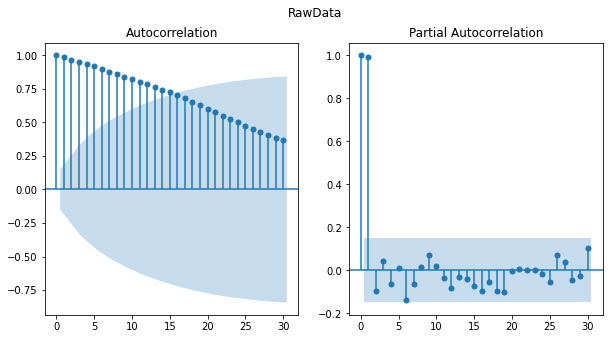

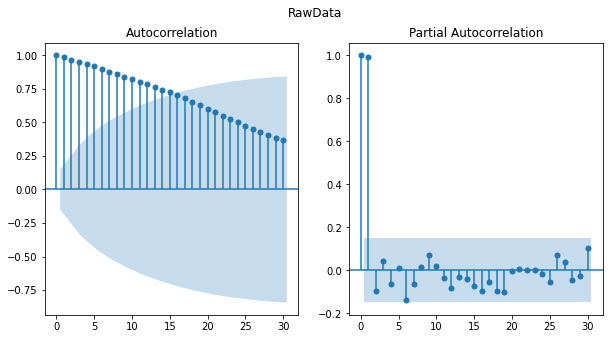

In [130]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_ym, test_size=0.2, shuffle=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("RawData")
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

#비정상성 시계열의 전형적인 특징을 보여준다. 완만히 하강하는 모양새. 정상성이라면 뚝 끊기게 나올 것

YM_DT
2003-12-01    17.442470
2004-01-01     7.332491
2004-02-01   -10.069218
2004-03-01     1.487454
2004-04-01    -0.595449
                ...    
2017-10-01   -33.795537
2017-11-01    -0.481454
2017-12-01   -16.411128
2018-01-01    64.940142
2018-02-01    -0.597556
Name: GOLD_PRICE, Length: 171, dtype: float64


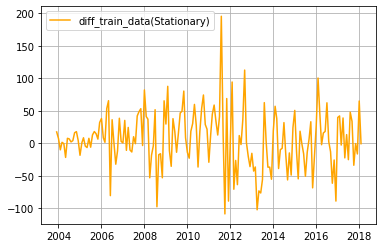

In [131]:
#차분한다.
diff_train_data = train_data.copy()
diff_train_data = diff_train_data["GOLD_PRICE"].diff()
diff_train_data.dropna(inplace=True)
print(diff_train_data)
plt.plot(diff_train_data, "orange", label="diff_train_data(Stationary)")
plt.grid()
plt.legend()

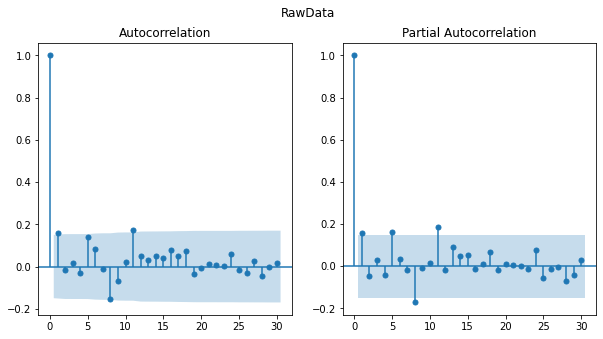

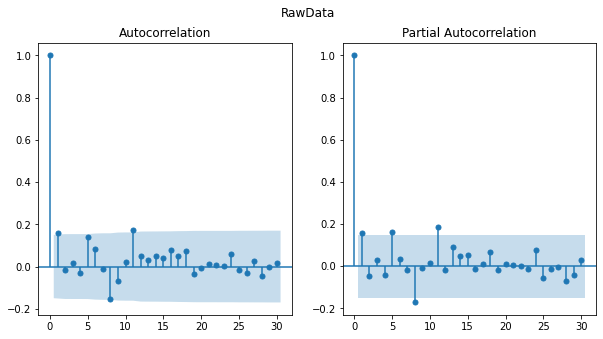

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("RawData")
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

#정상성을 보이는 것으로 보임. 3~4개 튀는 것들이 있으나 무시해도 좋음

In [210]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q)) #세가지 배열의 값을 각각 조합하여 새로운 배열로 만들어 줌
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]

aic = []
for i in pdq:
    for j in seasonal_pdq:
        try: #pdq 파라미터 값 때문에 오류가 날 수 있음. 코드가 중단되므로 try문으로...
            model = sm.tsa.SARIMAX(df_ym.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print("SARIMA Order : {}{} -> AIC : {}".format(i, j, model_fit.aic))
            aic_dict = { "pdq": i, "s-pdq" : j, "aic" : model_fit.aic }
            aic.append(aic_dict)
        except:
            continue
result_by_aic = pd.DataFrame(aic)
result_by_aic.sort_values(by="aic", ascending=True, inplace=True)
result_by_aic.reset_index(inplace=True)
result_by_aic

SARIMA Order : (0, 1, 0)(0, 1, 0, 4) -> AIC : 2337.8623105141523
SARIMA Order : (0, 1, 0)(0, 1, 1, 4) -> AIC : 2207.4998029846693
SARIMA Order : (0, 1, 0)(0, 1, 2, 4) -> AIC : 2209.499649372441
SARIMA Order : (0, 1, 0)(1, 1, 0, 4) -> AIC : 2294.142835709674
SARIMA Order : (0, 1, 0)(1, 1, 1, 4) -> AIC : 2209.497222094422
SARIMA Order : (0, 1, 0)(1, 1, 2, 4) -> AIC : 2210.3570265075277
SARIMA Order : (0, 1, 0)(2, 1, 0, 4) -> AIC : 2252.9877031651276
SARIMA Order : (0, 1, 0)(2, 1, 1, 4) -> AIC : 2208.1569199645733
SARIMA Order : (0, 1, 0)(2, 1, 2, 4) -> AIC : 2209.7007714652245
SARIMA Order : (0, 1, 1)(0, 1, 0, 4) -> AIC : 2335.411445470114
SARIMA Order : (0, 1, 1)(0, 1, 1, 4) -> AIC : 2199.340278327929
SARIMA Order : (0, 1, 1)(0, 1, 2, 4) -> AIC : 2201.0554101720386
SARIMA Order : (0, 1, 1)(1, 1, 0, 4) -> AIC : 2288.085675205498
SARIMA Order : (0, 1, 1)(1, 1, 1, 4) -> AIC : 2201.1260136198434
SARIMA Order : (0, 1, 1)(1, 1, 2, 4) -> AIC : 2202.322315415971
SARIMA Order : (0, 1, 1)(2, 1, 0

,index,pdq,s-pdq,aic
0,10,"(0, 1, 1)","(0, 1, 1, 4)",2199.340278
1,16,"(0, 1, 1)","(2, 1, 1, 4)",2199.847133
2,37,"(1, 1, 1)","(0, 1, 1, 4)",2200.082806
3,28,"(1, 1, 0)","(0, 1, 1, 4)",2200.620514
4,43,"(1, 1, 1)","(2, 1, 1, 4)",2200.671267
...,...,...,...,...
76,45,"(1, 1, 2)","(0, 1, 0, 4)",2317.151573
77,9,"(0, 1, 1)","(0, 1, 0, 4)",2335.411445
78,27,"(1, 1, 0)","(0, 1, 0, 4)",2336.006621
79,54,"(2, 1, 0)","(0, 1, 0, 4)",2336.839585


In [211]:
#aic가 가장 낮은 모델로 select 하여 summary를 본다
model_opt = sm.tsa.SARIMAX(df_ym.values, order=result_by_aic.iloc[0,1], seasonal_order=result_by_aic.iloc[0,2])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  215
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood               -1096.670
Date:                           Fri, 10 Sep 2021   AIC                           2199.340
Time:                                   18:46:49   BIC                           2209.382
Sample:                                        0   HQIC                          2203.400
                                           - 215                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2342      0.062      3.794      0.000       0.113       0.355
ma.S.L4       -0.9947      0.270     -3.689      0.000      -1.523      -0.466
sigma2      1873.4232    498.290      3.760      0.000     896.793    2850.054
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                13.57
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                             0.18
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [215]:
df_ym2 = df_ym.copy()

dt_index = pd.date_range(start="2021-10-1", end="2023-9-1", freq="MS")
df_dt = pd.DataFrame(dt_index)
df_dt["GOLD_PRICE"] = 0.0
df_dt["YM_DT"] = df_dt[0]
df_dt.drop(columns=[0], axis=1, inplace=True)
df_dt.set_index("YM_DT", inplace=True)
df_ym2 = pd.concat([df_ym2, df_dt])
df_ym2[-24:].index

DatetimeIndex(['2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01'],
              dtype='datetime64[ns]', name='YM_DT', freq=None)

Text(0.5, 0.98, 'SARIMA (0, 1, 1) (0, 1, 1, 4), Prediction Results')

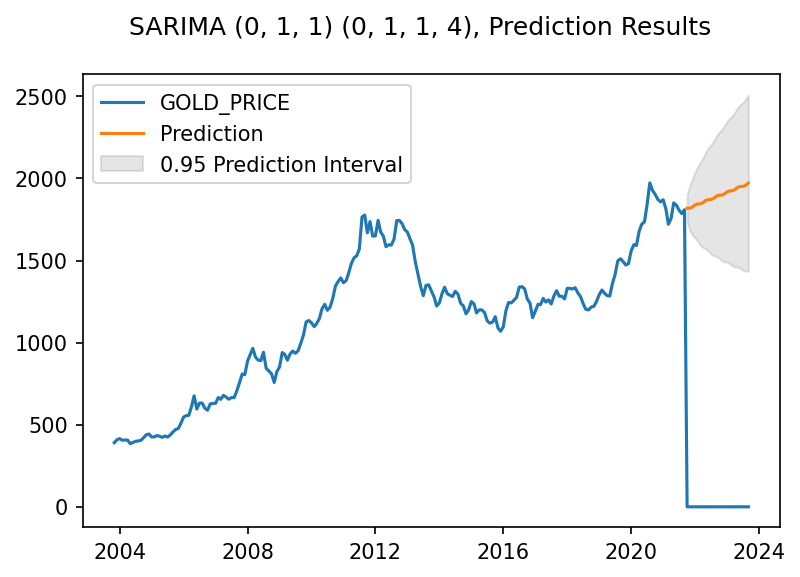

In [218]:
import datetime
import numpy as np
from sklearn.metrics import r2_score

prediction = model_opt_fit.get_forecast(24)
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(df_ym2[-24:].index)
# r2 = r2_score(test_data, predicted_value)

forecast_start_date = datetime.datetime(2021, 9, 1)
forecast_start_date = np.datetime64(forecast_start_date)
plt.figure(dpi=150)
plt.plot(df_ym2.index, df_ym2["GOLD_PRICE"], label="GOLD_PRICE")
# plt.vlines(forecast_start_date, 0, 2000, linestyle="--", color="r", label="Forecast Start")
plt.plot(predict_index, predicted_value, label = "Prediction")
plt.fill_between(predict_index, predicted_lb, predicted_ub, color="k", alpha=0.1, label="0.95 Prediction Interval")
plt.legend(loc="upper left")
plt.suptitle("SARIMA {} {}, Prediction Results".format(result_by_aic.iloc[0,1], result_by_aic.iloc[0,2]))